# Lectures on Machine Learning for Strong Gravity
## Lecture 2: Autoencoders and Generative Adversarial Networks

To test it, simply press Ctrl+Enter sequentially in each cell, or click on the small icons on the left with the "play" symbol.

<br>

<a href="https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture2_Autoencoders_and_Generative_Adversarial_Networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### In this lecture, you will learn:
1. How to reduce the dimensionality of data by finding an appropriate basis of vectors.
2. How autoencoders "compress" the data by automatically identifying the governing parameters.
3. How we can use GANs to generate samples from the same distribution as the training data.<br>Original paper:<br>

 - Felipe F. Freitas, Carlos A. R. Herdeiro, António P. Morais, António Onofre, Roman Pasechnik, Eugen Radu, Nicolas Sanchis-Gual, Rui Santos, <i>Generating gravitational waveform libraries of exotic compact binaries with deep learning</i>, 2022. https://arxiv.org/abs/2203.01267
 
<br>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('You are now using:', device)

You are now using: cpu


# 1. Toy Model Waveforms

Let's first create a dataset of toy "waveforms" of the form

$$\psi = \sin(2 \pi k x)\, e^{-8x^2}.$$

we will use these as examples to train our models.

<br>

In [6]:
def show_some_cases(dataset1, dataset2 = None):
    fig, ax = plt.subplots(2,3, figsize = (12, 4));
    font = {'size'   : 10}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, 64, dtype = np.float32)
    for i in range(2):
        for j in range(3):
            if dataset2 is not None:
                ax[i,j].plot(x, dataset1[j + 3*i, :], 'b', label = 'Data')
                ax[i,j].plot(x, dataset2[j + 3*i, :], 'r--', label = 'Approx')
                ax[i,j].legend(loc = 'upper left')
            else:
                ax[i,j].plot(x, dataset1[j + 3*i, :], 'b')

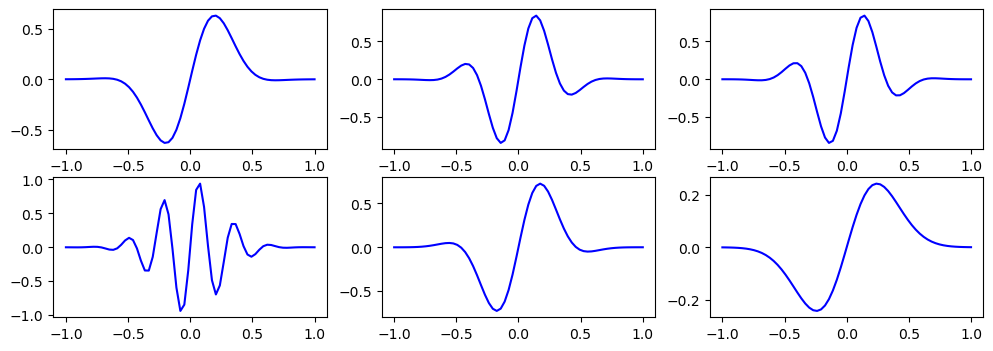

In [12]:
x       = np.linspace(-1, 1, 64, dtype = np.float32)
randoms = 5*np.random.rand(100)
data    = torch.tensor(np.array([    np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 ) for k in randoms]))

data_train, data_test = data[:60, :], data[60:, :]

show_some_cases(data_train)

# 2. Principal Component Analysis / Singular Value Decomposition

First we use linear algebra algorithms to express the waveforms as a linear combination of a few wisely chosen vectors:

<br>

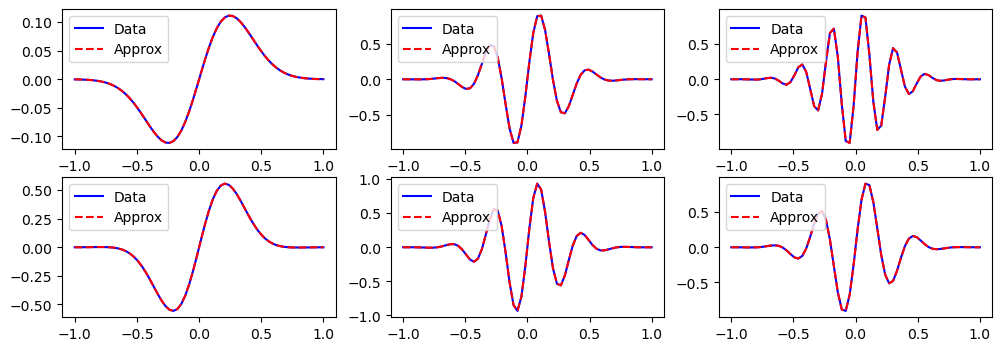

In [10]:
pca = PCA(n_components = 10)
pca.fit(data_train)

encoded = pca.transform(data_test)
decoded = pca.inverse_transform(encoded)

show_some_cases(data_test, decoded)

What are the first representative vectors?
<br>

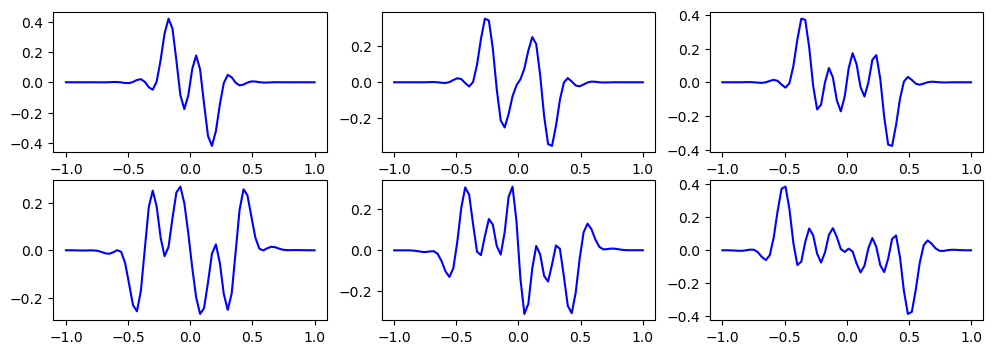

In [6]:
show_some_cases(pca.components_)

And what is their importance representing the data?
<br>

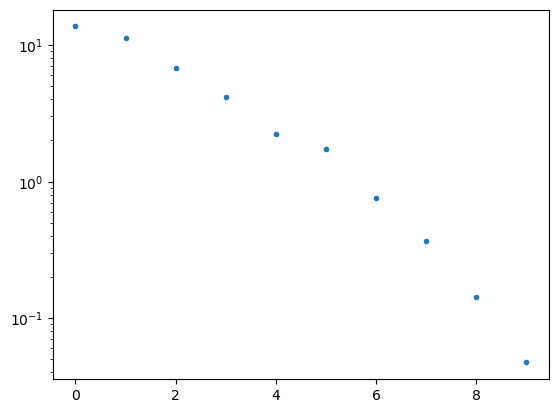

In [11]:
plt.yscale('log')
plt.plot(pca.singular_values_, '.');

## Challenges!
 - Try other algorithms, such as TruncatedSVD instead of PCA. What changes do you see?
 - How much can you reduce the number of components before the approximation gets bad?
 
 <br>

# 3. Autoencoder

An autoencoder introduces a bottleneck in a neural network, so the model is forced to "summarize" the data in a few parameters. The result is similar to PCA/SVD, but it can cpture nonlinear dependences.

<br>

In [22]:
wave_size   = 64
num_samples = 1024

batch_size = 64
lr         = 0.00002
beta1      = 0.5
niter      = 25

nz  = 2     # Size of latent vector
nef = 64    # Filter size of encoder
ndf = 64    # Filter size of decoder
nc  = 1     # Output wave channels

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def show_some_cases(dataset1, dataset2 = None):
    fig, ax = plt.subplots(2,3, figsize = (12, 4));
    font = {'size'   : 10}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, wave_size, dtype = np.float32)
    for i in range(2):
        for j in range(3):
            if dataset2 is not None:
                ax[i,j].plot(x, dataset1[j + 3*i, 0, :], 'b', label = 'Data')
                ax[i,j].plot(x, dataset2[j + 3*i, 0, :], 'r--', label = 'Approx')
                ax[i,j].legend(loc = 'upper left')
            else:
                ax[i,j].plot(x, dataset1[j + 3*i, 0, :], 'b')


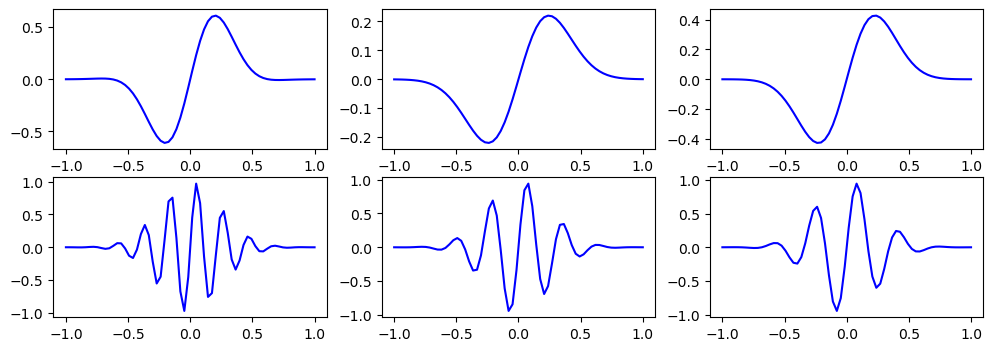

In [32]:
x       = np.linspace(-1, 1, wave_size, dtype = np.float32)
randoms = 5 * np.random.rand(num_samples)
data    = torch.tensor(np.array([ \
                                 np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 )  \
                                 for k in randoms])).reshape(num_samples, 1, wave_size)

data_train, data_test = data[: 3 * num_samples //4, :], data[3 * num_samples //4:, :]
randoms_train         = randoms[: 3 * num_samples //4]

show_some_cases(data_train)

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # input is (nc) x 64
            nn.Conv1d(nc, nef, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nef) x 32
            nn.Conv1d(nef, nef * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(nef * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nef*2) x 16
            nn.Conv1d(nef * 2, nef * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(nef * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nef*4) x 8
            nn.Conv1d(nef * 4, nef * 8, 4, 2, 1, bias=False),
            nn.BatchNorm1d(nef * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nef*8) x 4
            nn.Conv1d(nef * 8, nz, 4, 1, 0, bias=False),
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose1d(     nz, ndf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.ReLU(True),
            # state size. (ndf*8) x 4
            nn.ConvTranspose1d(ndf * 8, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.ReLU(True),
            # state size. (ndf*4) x 8
            nn.ConvTranspose1d(ndf * 4, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.ReLU(True),
            # state size. (ndf*2) x 16
            nn.ConvTranspose1d(ndf * 2,     ndf, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf),
            nn.ReLU(True),
            # state size. (ndf) x 32
            nn.ConvTranspose1d(    ndf,      nc, 4, 2, 1, bias=False),
            # state size. (nc) x 64
        )
                
    def forward(self, x):
        return self.decoder(self.encoder(x))
    

## 3. 1. Training with 1-parameter dependence

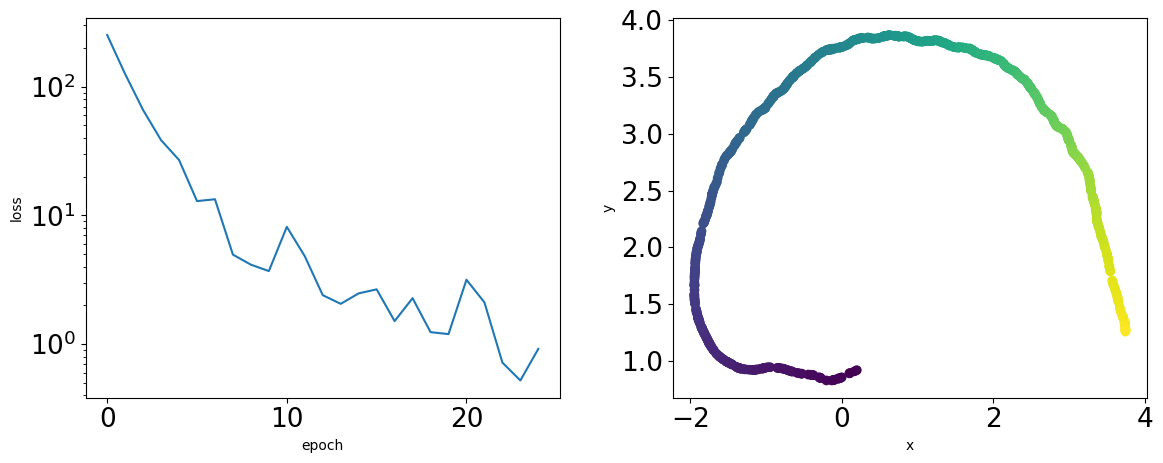

In [33]:
auto_encoder  = AutoEncoder().to(device)
auto_encoder.apply(weights_init)

loss_hist = []

optimizer = optim.Adam(auto_encoder.parameters(), lr, betas=(beta1, 0.999))

data_loader = DataLoader(data_train, batch_size = batch_size, shuffle=True)
data_device = data_train.to(device)

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(niter):
    try:
        for X in data_loader:

            X_device = X.to(device)
            optimizer.zero_grad()

            reconstructed = auto_encoder(X_device)
            loss = torch.sum((X_device - reconstructed)**2)
            
            loss.backward()
            optimizer.step()
            
        loss_hist.append(loss.item())
        latent = auto_encoder.encoder(data_device).cpu().detach().numpy()

        ax1.cla()
        ax1.set_yscale('log')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(latent[:,0], latent[:,1], c = randoms_train)

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

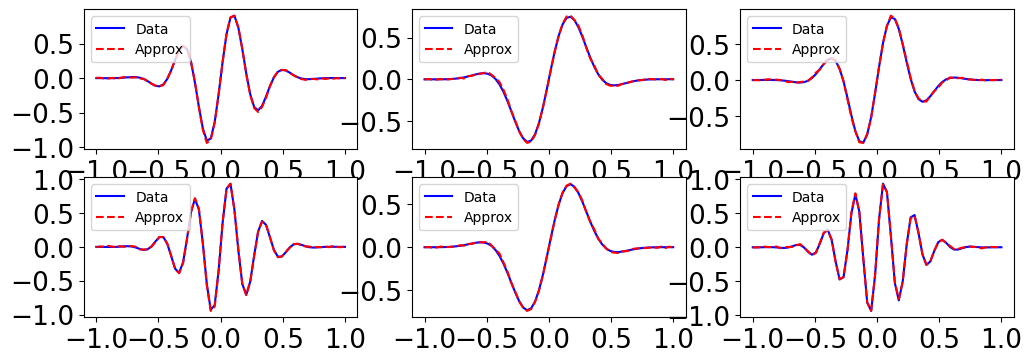

In [34]:
data_device = data_test.to(device)

encoded = auto_encoder.encoder(data_device)
decoded = auto_encoder.decoder(encoded)

show_some_cases(data_test, decoded.cpu().detach().numpy())

## 3.2. Let's try a 2-parameter dependence

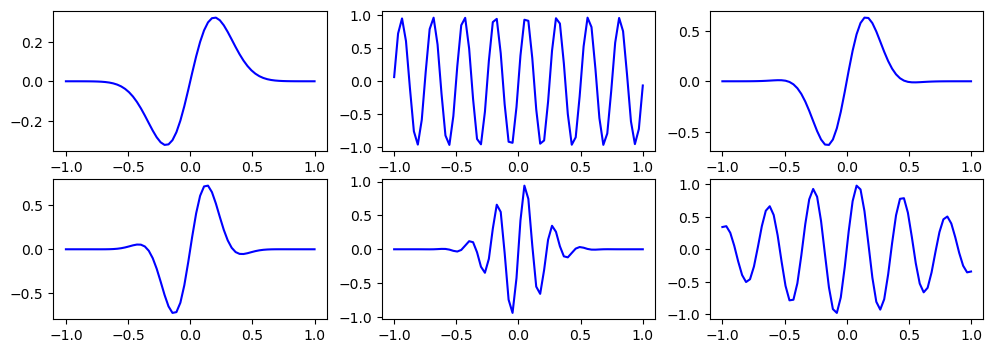

In [35]:
x        = np.linspace(-1, 1, wave_size, dtype = np.float32)
randoms1 = 5 * np.random.rand(num_samples)
randoms2 = 2 * np.random.rand(num_samples)
data     = torch.tensor(np.array([ \
                                  np.sin(2 * k1 * np.pi * x) * np.exp(- k2 * 8 * x**2 ) \
                                  for k1, k2 in zip(randoms1, randoms2)])).reshape(num_samples, 1, wave_size)

data_train, data_test = data[: 3 * num_samples //4, :], data[3 * num_samples //4:, :]
randoms1_train        = randoms1[: 3 * num_samples //4]
randoms2_train        = randoms2[: 3 * num_samples //4]

show_some_cases(data_train)

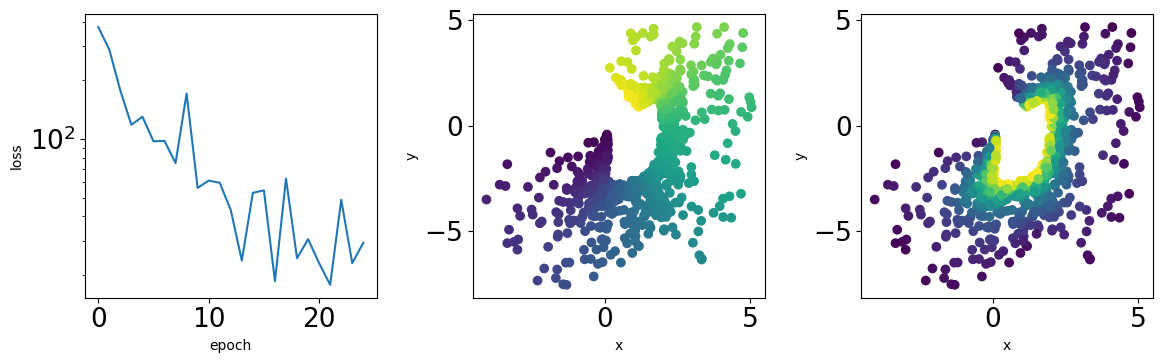

In [36]:
auto_encoder  = AutoEncoder().to(device)
auto_encoder.apply(weights_init)

loss_hist = []

optimizer = optim.Adam(auto_encoder.parameters(), lr, betas=(beta1, 0.999))

data_loader = DataLoader(data_train, batch_size = batch_size, shuffle=True)
data_device = data_train.to(device)

################## Training and Plotting ##################

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(niter):
    try:
        for X in data_loader:

            X_device = X.to(device)
            optimizer.zero_grad()

            reconstructed = auto_encoder(X_device)
            loss = torch.sum((X_device - reconstructed)**2)
            
            loss.backward()
            optimizer.step()
        
        loss_hist.append(loss.item())
        latent = auto_encoder.encoder(data_device).cpu().detach().numpy()

        ax1.cla()
        ax1.set_yscale('log')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(latent[:,0], latent[:,1], c = randoms1_train)
        
        ax3.cla()
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.scatter(latent[:,0], latent[:,1], c = randoms2_train)

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

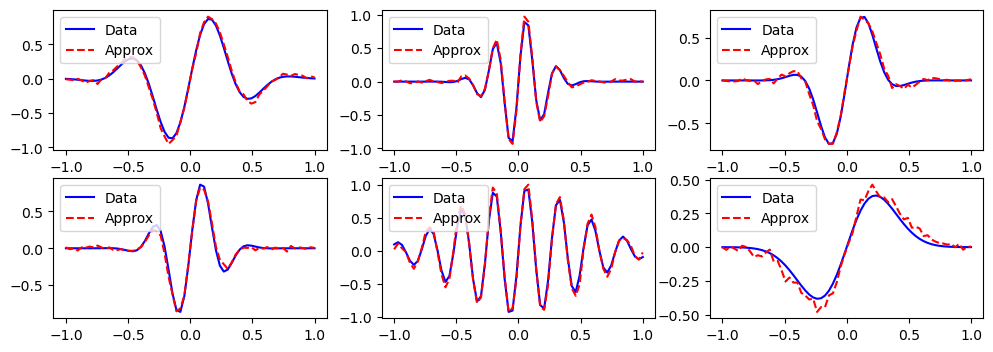

In [38]:
data_device = data_test.to(device)

encoded = auto_encoder.encoder(data_device)
decoded = auto_encoder.decoder(encoded)

show_some_cases(data_test, decoded.cpu().detach().numpy())

# 4. Generative Adversarial Networks (GANs)

Generative Adversarial Networks try to create samples with the same probability distribution as our dataset. They have two parts:

 - The Generator: Takes a vector of normally distributed random values, and tries to translate them to convincing fake data.
 - The Discriminator: Tries to discriminate between real and fake data.

During the training, the generator learns to make better and better data. meanwhile, the discriminator becomes better and better at identifying the false data from the generator.

<br>

In [21]:
X = torch.normal(0., 1., (1024, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.02)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5,3),
            nn.Tanh(),
            nn.Linear(3,1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.02)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)

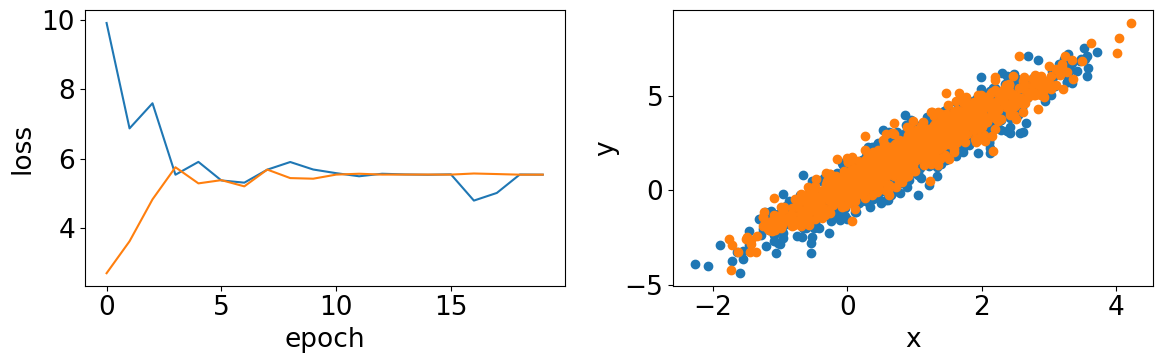

In [24]:
generator     = Generator()
discriminator = Discriminator()

gen_loss_hist = []
dis_loss_hist = []

gen_optimizer = optim.Adam(generator.parameters(), lr=0.005)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=0.05)

data_loader = DataLoader(data, batch_size = 8, shuffle=True)

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(20):
    try:
        for X in data_loader:
            loss_function = nn.BCEWithLogitsLoss(reduction='sum')
            latent_space_points = torch.normal(0, 1, size=(8, 2))

            ################## Train the Discriminator ##################
            dis_optimizer.zero_grad()
            fake_data = generator(latent_space_points)

            real_data_evaluation = discriminator(X)
            fake_data_evaluation = discriminator(fake_data.detach())

            real_data_loss = loss_function(real_data_evaluation, torch.ones(8, 1))
            fake_data_loss = loss_function(fake_data_evaluation, torch.zeros(8, 1))

            dis_loss = (real_data_loss + fake_data_loss)/2
            
            dis_loss.backward()
            dis_optimizer.step()
            #############################################################

            #################### Train the Generator ####################
            gen_optimizer.zero_grad()
            fake_data = generator(latent_space_points)

            fake_data_evaluation = discriminator(fake_data)
            gen_loss = loss_function(fake_data_evaluation, torch.ones(8, 1))

            gen_loss.backward()
            gen_optimizer.step()                             
            #############################################################
        
        dis_loss_hist.append(dis_loss.item())
        gen_loss_hist.append(gen_loss.item())
        
        latent_space_points = torch.normal(0, 1, size=(1024, 2))
        fake_data = generator(latent_space_points).cpu().detach().numpy()
        real_data = data

        ax1.cla()
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(gen_loss_hist)
        ax1.plot(dis_loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(real_data[:, 0], real_data[:, 1])
        ax2.scatter(fake_data[:, 0], fake_data[:, 1])

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

# 5. Deep Convolutional GAN for waveforms

Let's try to create fake waveforms! In this case we need more complex neural networks (convolutional), so please enable a GPU on Google Colab by going to "Edit" > "Notebook settings" and select “GPU”. You may need to restart the kernel and run the first cell with the libraries.

<br>

In [25]:
wave_size   = 64
num_samples = 1024

batch_size = 64
lr         = 0.0002
beta1      = 0.5
niter      = 25

nz  = 10    # Size of latent vector
ngf = 64    # Filter size of generator
ndf = 64    # Filter size of discriminator
nc  = 1     # Output wave channels

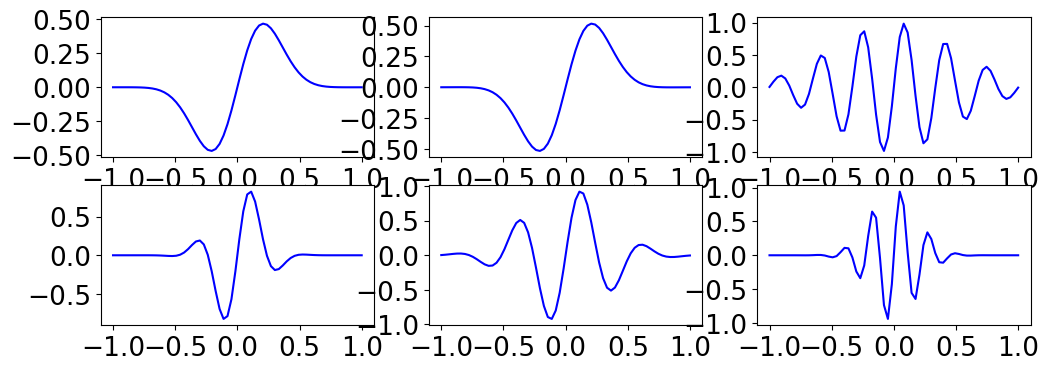

In [26]:
x        = np.linspace(-1, 1, wave_size, dtype = np.float32)
randoms1 = 5 * np.random.rand(num_samples)
randoms2 = 2 * np.random.rand(num_samples)
data     = torch.tensor(np.array([ \
                                  np.sin(2 * k1 * np.pi * x) * np.exp(- k2 * 8 * x**2 ) \
                                  for k1, k2 in zip(randoms1, randoms2)])).reshape(num_samples, 1, wave_size)

show_some_cases(data)

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose1d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8
            nn.ConvTranspose1d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16
            nn.ConvTranspose1d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32
            nn.ConvTranspose1d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64
        )

    def forward(self, input):
        output = self.net(input)
        return output

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # input is (nc) x 64
            nn.Conv1d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32
            nn.Conv1d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16
            nn.Conv1d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8
            nn.Conv1d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4
            nn.Conv1d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.net(input)
        return output.view(-1, 1).squeeze(1)

In [31]:
generator     = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

real_label = torch.ones(batch_size).to(device)
fake_label = torch.zeros(batch_size).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr, betas=(beta1, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr, betas=(beta1, 0.999))
loss_function = nn.BCELoss().to(device)

data_loader   = DataLoader(data, batch_size = batch_size, shuffle=True)
gen_loss_hist = []
dis_loss_hist = []

for epoch in range(niter):
    print(epoch, end = ' ')
    for i, X in enumerate(data_loader, 0):
        
        X_device = X.to(device)
        latent_space_points = torch.normal(0, 1, size = (batch_size, nz, 1)).to(device)
        
        ################## Train the Discriminator ##################
        
        discriminator.zero_grad()

        fake_data = generator(latent_space_points)

        real_data_evaluation = discriminator(X_device)
        fake_data_evaluation = discriminator(fake_data.detach())

        real_data_loss = loss_function(real_data_evaluation, real_label)
        fake_data_loss = loss_function(fake_data_evaluation, fake_label)

        dis_loss = (real_data_loss + fake_data_loss) / 2

        dis_loss.backward()
        dis_optimizer.step()

        #############################################################

        #################### Train the Generator ####################
        
        gen_optimizer.zero_grad()
        fake_data = generator(latent_space_points)

        fake_data_evaluation = discriminator(fake_data)
        gen_loss = loss_function(fake_data_evaluation, real_label)

        gen_loss.backward()
        gen_optimizer.step()  

        #############################################################


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

How do the fake waveforms look like?

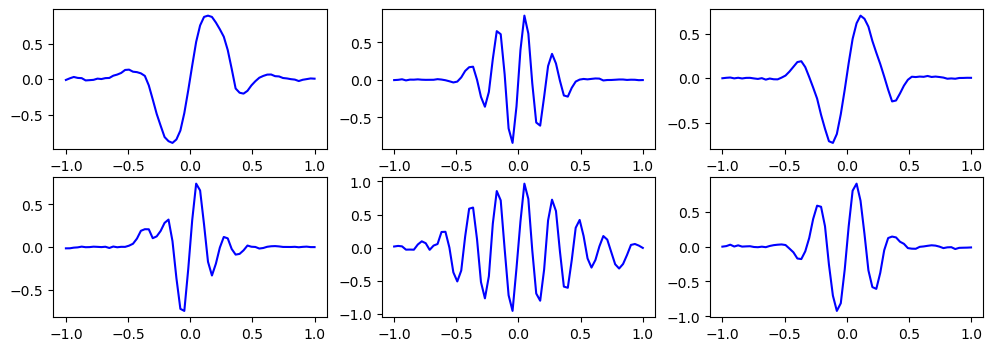

In [32]:
fixed_noise = torch.normal(0, 1, size = (6, nz, 1)).to(device)
test = generator(fixed_noise)
show_some_cases(test.cpu().detach().numpy())